In [1]:
# corrected_edugen_vae_scienceqa.py
import os
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
import tensorflow as tf
from tensorflow.keras import layers, Model, optimizers


# -----------------------
# Config
# -----------------------
IMG_SIZE = 128
CHANNELS = 3
BATCH_SIZE = 32
LATENT_DIM = 256
EPOCHS = 100
LEARNING_RATE = 1e-4
BETA = 0.5
MODEL_DIR = "./vae_model_fixed"
os.makedirs(MODEL_DIR, exist_ok=True)

# -----------------------
# Preprocess
# -----------------------
def preprocess_pil_image(pil_img):
    img = pil_img.convert("RGB").resize((IMG_SIZE, IMG_SIZE))
    arr = np.asarray(img, dtype=np.float32) / 255.0
    return arr

# -----------------------
# Load HuggingFace dataset
# -----------------------
print("Loading dataset...")
ds = load_dataset("derek-thomas/ScienceQA")  # assumes internet or cached

# compute counts and steps
train_count = len(ds["train"])
val_count = len(ds["validation"])
test_count = len(ds["test"])
print(f"Train: {train_count}, Val: {val_count}, Test: {test_count}")

steps_per_epoch = max(1, train_count // BATCH_SIZE)
validation_steps = max(1, val_count // BATCH_SIZE)

# -----------------------
# Make tf.data datasets
# -----------------------
def make_tf_dataset(split="train", batch_size=BATCH_SIZE, repeat=False, shuffle=True):
    # create a generator that yields items every time it's iterated
    def gen():
        while True:
            for ex in ds[split]:
                img = ex["image"]
                if img is None:
                    continue
                yield preprocess_pil_image(img)
            if not repeat:
                break

    output_signature = tf.TensorSpec(shape=(IMG_SIZE, IMG_SIZE, CHANNELS), dtype=tf.float32)
    tfds = tf.data.Dataset.from_generator(gen, output_signature=output_signature)
    if shuffle:
        tfds = tfds.shuffle(2048)
    tfds = tfds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return tfds

# For training we want the generator to not stop across epochs -> set repeat=True internally via the while True in gen above.
train_ds = make_tf_dataset("train", repeat=True, shuffle=True)
val_ds   = make_tf_dataset("validation", repeat=False, shuffle=False)
test_ds  = make_tf_dataset("test", repeat=False, shuffle=False)

print("Train batches per epoch (approx):", steps_per_epoch)
print("Validation steps (approx):", validation_steps)


Loading dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001-1028f23e353fbe(…):   0%|          | 0.00/377M [00:00<?, ?B/s]

data/validation-00000-of-00001-6c7328ff6(…):   0%|          | 0.00/126M [00:00<?, ?B/s]

data/test-00000-of-00001-f0e719df791966f(…):   0%|          | 0.00/122M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/12726 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/4241 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/4241 [00:00<?, ? examples/s]

Train: 12726, Val: 4241, Test: 4241
Train batches per epoch (approx): 397
Validation steps (approx): 132


In [2]:
# # -----------------------
# # Downsample datasets to 10% of original
# # -----------------------
# def downsample_dataset(split, fraction=0.1, batch_size=BATCH_SIZE, shuffle=True):
#     total_count = len(ds[split])
#     take_count = max(1, int(total_count * fraction))

#     def gen():
#         for idx, ex in enumerate(ds[split]):
#             if idx >= take_count:
#                 break
#             img = ex["image"]
#             if img is None:
#                 continue
#             yield preprocess_pil_image(img)

#     output_signature = tf.TensorSpec(shape=(IMG_SIZE, IMG_SIZE, CHANNELS), dtype=tf.float32)
#     tfds = tf.data.Dataset.from_generator(gen, output_signature=output_signature)
#     if shuffle:
#         tfds = tfds.shuffle(1024)
#     tfds = tfds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
#     return tfds

# # Apply downsampling
# train_ds = downsample_dataset("train", fraction=0.1, shuffle=False)
# val_ds   = downsample_dataset("validation", fraction=0.1, shuffle=False)
# test_ds  = downsample_dataset("test", fraction=0.1, shuffle=False)

# # Update steps_per_epoch and validation_steps
# steps_per_epoch = max(1, int(len(ds["train"]) * 0.1) // BATCH_SIZE)
# validation_steps = max(1, int(len(ds["validation"]) * 0.1) // BATCH_SIZE)

# print("After downsampling:")
# print("Train batches per epoch (approx):", steps_per_epoch)
# print("Validation steps (approx):", validation_steps)

# print("Train (after downsampling):", int(len(ds["train"]) * 0.1))
# print("Validation (after downsampling):", int(len(ds["validation"]) * 0.1))
# print("Test (after downsampling):", int(len(ds["test"]) * 0.1))


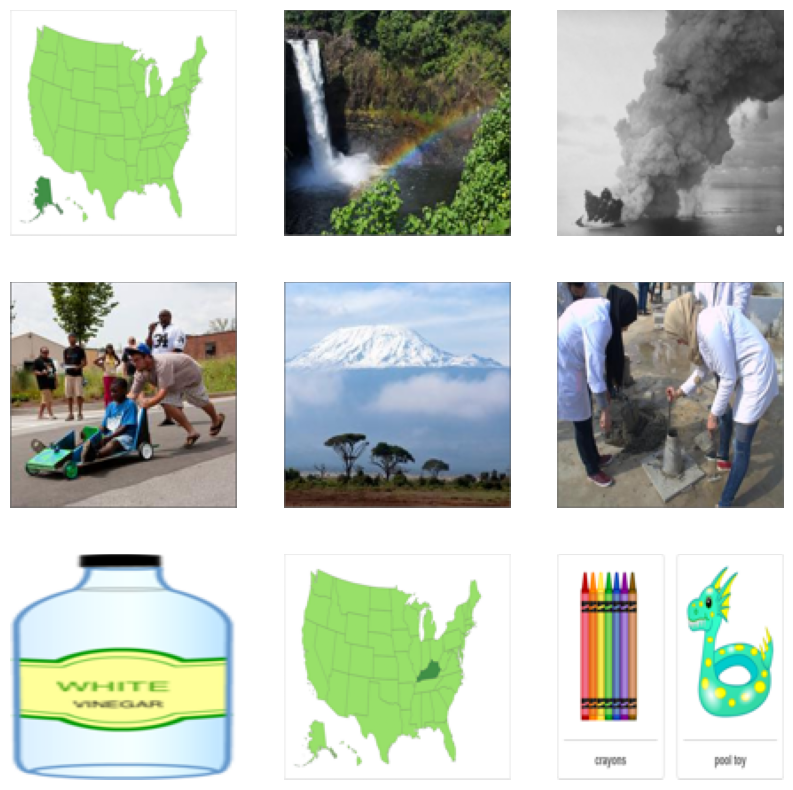

In [6]:
import matplotlib.pyplot as plt

# Take a batch from the training dataset
for batch in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(min(9, batch.shape[0])):
        plt.subplot(3, 3, i + 1)
        plt.imshow(batch[i])
        plt.axis("off")
    plt.show()

In [7]:

# -----------------------
# VAE definition (with test_step)
# -----------------------
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        eps = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * eps

def build_encoder(img_size=IMG_SIZE, channels=CHANNELS, latent_dim=LATENT_DIM):
    inputs = layers.Input(shape=(img_size, img_size, channels))
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(inputs)
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2D(256, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    return Model(inputs, [z_mean, z_log_var, z], name="encoder")

def build_decoder(img_size=IMG_SIZE, channels=CHANNELS, latent_dim=LATENT_DIM):
    latent_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(8*8*256, activation="relu")(latent_inputs)
    x = layers.Reshape((8,8,256))(x)
    x = layers.Conv2DTranspose(128, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(16, 3, strides=2, padding="same", activation="relu")(x)
    outputs = layers.Conv2D(channels, 3, activation="sigmoid", padding="same")(x)
    return Model(latent_inputs, outputs, name="decoder")

class VAE(Model):
    def __init__(self, encoder, decoder, beta=1.0, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta
        self.total_loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.recon_loss_tracker = tf.keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.recon_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data, training=True)
            reconstruction = self.decoder(z, training=True)
            recon_loss = tf.reduce_mean(tf.reduce_sum(tf.math.squared_difference(data, reconstruction), axis=[1,2,3]))
            kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))
            total_loss = recon_loss + self.beta * kl_loss
        grads = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {"loss": self.total_loss_tracker.result(),
                "recon_loss": self.recon_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result()}

    # IMPORTANT: implement test_step so validation doesn't require a compiled loss
    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        z_mean, z_log_var, z = self.encoder(data, training=False)
        reconstruction = self.decoder(z, training=False)
        recon_loss = tf.reduce_mean(tf.reduce_sum(tf.math.squared_difference(data, reconstruction), axis=[1,2,3]))
        kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))
        total_loss = recon_loss + self.beta * kl_loss
        # update metrics (these are the same trackers used in training)
        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {"loss": self.total_loss_tracker.result(),
                "recon_loss": self.recon_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result()}

    def call(self, inputs, training=False):
        _, _, z = self.encoder(inputs, training=training)
        return self.decoder(z, training=training)

# Build & compile
encoder = build_encoder()
decoder = build_decoder()
vae = VAE(encoder, decoder, beta=BETA)
vae.compile(optimizer=optimizers.Adam(LEARNING_RATE))


In [8]:

# -----------------------
# Sampling Layer
# -----------------------
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        eps = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * eps

# -----------------------
# Encoder with LeakyReLU
# -----------------------
def build_encoder(img_size=IMG_SIZE, channels=CHANNELS, latent_dim=LATENT_DIM):
    inputs = layers.Input(shape=(img_size, img_size, channels))
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Conv2D(64, 3, strides=2, padding="same")(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Conv2D(256, 3, strides=2, padding="same")(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    return Model(inputs, [z_mean, z_log_var, z], name="encoder")

# -----------------------
# Decoder with LeakyReLU
# -----------------------
def build_decoder(img_size=IMG_SIZE, channels=CHANNELS, latent_dim=LATENT_DIM):
    latent_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(8 * 8 * 256)(latent_inputs)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Reshape((8, 8, 256))(x)
    x = layers.Conv2DTranspose(128, 3, strides=2, padding="same")(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Conv2DTranspose(64, 3, strides=2, padding="same")(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Conv2DTranspose(32, 3, strides=2, padding="same")(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Conv2DTranspose(16, 3, strides=2, padding="same")(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    outputs = layers.Conv2D(channels, 3, activation="sigmoid", padding="same")(x)
    return Model(latent_inputs, outputs, name="decoder")

# -----------------------
# VAE Model Definition
# -----------------------
class VAE(Model):
    def __init__(self, encoder, decoder, beta=1.0, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta
        self.total_loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.recon_loss_tracker = tf.keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.recon_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data, training=True)
            reconstruction = self.decoder(z, training=True)
            recon_loss = tf.reduce_mean(tf.reduce_sum(tf.square(data - reconstruction), axis=[1,2,3]))
            kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))
            total_loss = recon_loss + self.beta * kl_loss
        grads = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {"loss": self.total_loss_tracker.result(),
                "recon_loss": self.recon_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result()}

    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        z_mean, z_log_var, z = self.encoder(data, training=False)
        reconstruction = self.decoder(z, training=False)
        recon_loss = tf.reduce_mean(tf.reduce_sum(tf.square(data - reconstruction), axis=[1,2,3]))
        kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))
        total_loss = recon_loss + self.beta * kl_loss
        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {"loss": self.total_loss_tracker.result(),
                "recon_loss": self.recon_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result()}

    def call(self, inputs, training=False):
        _, _, z = self.encoder(inputs, training=training)
        return self.decoder(z, training=training)

# -----------------------
# Build & Compile Model
# -----------------------
encoder = build_encoder()
decoder = build_decoder()
vae = VAE(encoder, decoder, beta=BETA)
vae.compile(optimizer=optimizers.Adam(LEARNING_RATE))

# Print model summary
encoder.summary()
decoder.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │        896 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 64, 64,    │          0 │ conv2d_5[0][0]    │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     18,496 │ leaky_re_lu[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 32, 32,    │          0 │ conv2d_6[0][0]    │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │     73,856 │ leaky_re_lu_1[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8, 256) │    295,168 │ leaky_re_lu_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 8, 8, 256) │          0 │ conv2d_8[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 16384)     │          0 │ leaky_re_lu_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 512)       │  8,389,120 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 512)       │          0 │ dense_2[0][0]     │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 256)       │    131,328 │ leaky_re_lu_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 256)       │    131,328 │ leaky_re_lu_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_1          │ (None, 256)       │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,040,192 (34.49 MB)

 Trainable params: 9,040,192 (34.49 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16384)          │     4,210,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 16, 16, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 32, 32, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 64, 64, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 128, 128, 16)   │         4,624 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 128, 128, 3)    │           435 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,603,043 (17.56 MB)

 Trainable params: 4,603,043 (17.56 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# -----------------------
# Fit with explicit steps_per_epoch and validation_steps
# -----------------------
print("Starting training...")
history = vae.fit(
    train_ds,
    epochs=100,
    steps_per_epoch=steps_per_epoch,       # number of train batches per epoch
    validation_data=val_ds,
    validation_steps=validation_steps     # number of val batches for validation
)

# Save
vae.build(input_shape=(None, IMG_SIZE, IMG_SIZE, CHANNELS)) # Build the model before saving weights
encoder.save(os.path.join(MODEL_DIR, "encoder.h5"))
decoder.save(os.path.join(MODEL_DIR, "decoder.h5"))
vae.save_weights(os.path.join(MODEL_DIR, "vae.weights.h5"))

# Save the entire VAE model (architecture + weights) for backend use
vae.save(os.path.join(MODEL_DIR, "vae_model.h5"))  # Save the whole model (architecture + weights)

print("Model saved successfully.")

Starting training...
Epoch 1/100
397/397 ━━━━━━━━━━━━━━━━━━━━ 113s 232ms/step - kl_loss: 126.7652 - loss: 3853.5295 - recon_loss: 3790.1482 - val_kl_loss: 101.8955 - val_loss: 1815.7919 - val_recon_loss: 1764.8440
Epoch 2/100
  1/397 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - kl_loss: 78.2839 - loss: 1947.0757 - recon_loss: 1907.9337

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


397/397 ━━━━━━━━━━━━━━━━━━━━ 91s 229ms/step - kl_loss: 108.9235 - loss: 1732.7950 - recon_loss: 1678.3331 - val_kl_loss: 141.6399 - val_loss: 1478.0538 - val_recon_loss: 1407.2339
Epoch 3/100
397/397 ━━━━━━━━━━━━━━━━━━━━ 90s 226ms/step - kl_loss: 143.6692 - loss: 1411.5468 - recon_loss: 1339.7124 - val_kl_loss: 157.9417 - val_loss: 1215.0144 - val_recon_loss: 1136.0433
Epoch 4/100
397/397 ━━━━━━━━━━━━━━━━━━━━ 88s 223ms/step - kl_loss: 160.0324 - loss: 1164.5609 - recon_loss: 1084.5447 - val_kl_loss: 165.7970 - val_loss: 1069.7517 - val_recon_loss: 986.8535
Epoch 5/100
397/397 ━━━━━━━━━━━━━━━━━━━━ 88s 223ms/step - kl_loss: 172.0611 - loss: 1025.4067 - recon_loss: 939.3762 - val_kl_loss: 181.1554 - val_loss: 968.1237 - val_recon_loss: 877.5459
Epoch 6/100
397/397 ━━━━━━━━━━━━━━━━━━━━ 91s 230ms/step - kl_loss: 183.6887 - loss: 931.8051 - recon_loss: 839.9609 - val_kl_loss: 185.9295 - val_loss: 871.9246 - val_recon_loss: 778.9597
Epoch 7/100
397/397 ━━━━━━━━━━━━━━━━━━━━ 83s 210ms/step - kl

Model saved successfully.


In [10]:

# -----------------------
# Evaluation (MSE & SSIM on some val batches)
# -----------------------
def evaluate_on_dataset(tf_dataset, max_batches=100):
    mse_vals = []
    ssim_vals = []
    cnt = 0
    for batch in tf_dataset:
        recon = vae(batch, training=False)
        batch_np = batch.numpy()
        recon_np = recon.numpy()
        mse_batch = np.mean((batch_np - recon_np)**2, axis=(1,2,3))
        mse_vals.extend(mse_batch.tolist())
        for i in range(batch_np.shape[0]):
            s = tf.image.ssim(batch_np[i], recon_np[i], max_val=1.0).numpy()
            ssim_vals.append(float(s))
        cnt += 1
        if cnt >= max_batches:
            break
    return np.mean(mse_vals), np.mean(ssim_vals)

print("Evaluating on validation (first 100 batches)...")
val_mse, val_ssim = evaluate_on_dataset(val_ds, max_batches=100)
print(f"Validation MSE: {val_mse:.6f}, SSIM: {val_ssim:.4f}")


Evaluating on validation (first 100 batches)...
Validation MSE: 0.007225, SSIM: 0.7106


In [11]:
# -----------------------
# Evaluation (MSE & SSIM on some train batches)
# -----------------------
def evaluate_on_dataset(tf_dataset, max_batches=50):  # smaller number for train set
    mse_vals = []
    ssim_vals = []
    cnt = 0
    for batch in tf_dataset:
        recon = vae(batch, training=False)
        batch_np = batch.numpy()
        recon_np = recon.numpy()
        # MSE per image
        mse_batch = np.mean((batch_np - recon_np)**2, axis=(1,2,3))
        mse_vals.extend(mse_batch.tolist())
        # SSIM per image
        for i in range(batch_np.shape[0]):
            s = tf.image.ssim(batch_np[i], recon_np[i], max_val=1.0).numpy()
            ssim_vals.append(float(s))
        cnt += 1
        if cnt >= max_batches:
            break
    return np.mean(mse_vals), np.mean(ssim_vals)

print("Evaluating on training set (first 50 batches)...")
train_mse, train_ssim = evaluate_on_dataset(train_ds, max_batches=50)
print(f"Training MSE: {train_mse:.6f}, SSIM: {train_ssim:.4f}")




Evaluating on training set (first 50 batches)...
Training MSE: 0.003881, SSIM: 0.7625


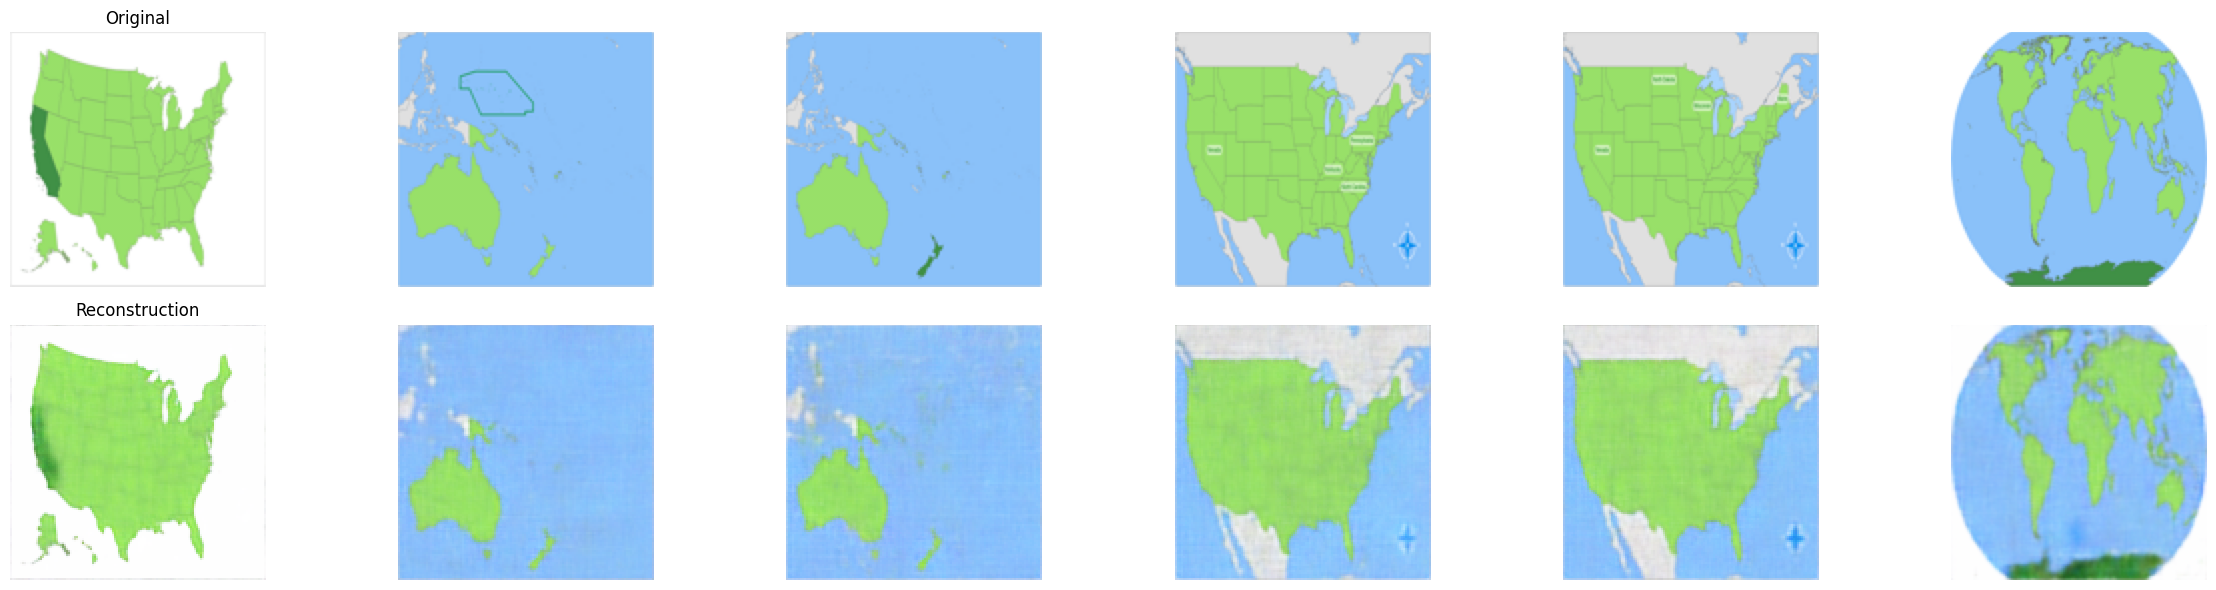

In [12]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def sample_indices_by_topic(split, topic_keyword="geography", max_samples=1000):
    """Return list of dataset indices from ds[split] whose topic matches topic_keyword."""
    topic_keyword = topic_keyword.lower().strip()
    indices = []
    for i, ex in enumerate(ds[split]):
        t = ex.get("topic", None)
        # handle None, str, list
        if t is None:
            continue
        if isinstance(t, list):
            t_vals = [str(x).lower() for x in t]
        else:
            t_vals = [str(t).lower()]
        # check substring match (so 'World Geography' also matches)
        if any(topic_keyword in tv for tv in t_vals):
            # ensure image exists
            if ex.get("image", None) is not None:
                indices.append(i)
    return indices

def show_reconstructions_for_topic(split="train", topic="geography", n=6, random_seed=42):
    # find candidate indices
    indices = sample_indices_by_topic(split, topic_keyword=topic)
    if len(indices) == 0:
        print(f"No images found for topic '{topic}' in split '{split}'.")
        return
    # choose n random indices
    random.seed(random_seed)
    n_show = min(n, len(indices))
    chosen = random.sample(indices, n_show)

    originals = []
    reconstructions = []

    for idx in chosen:
        ex = ds[split][idx]
        pil_img = ex.get("image", None)
        if pil_img is None:
            continue
        arr = preprocess_pil_image(pil_img)                    # your preprocessing function
        arr_tf = tf.expand_dims(arr, axis=0)                   # shape (1,H,W,C)
        recon_tf = vae(arr_tf, training=False)                 # runs through your VAE
        recon_np = recon_tf.numpy()[0]
        originals.append(arr)
        reconstructions.append(recon_np)

    # plotting
    m = len(originals)
    cols = min(n, m)
    plt.figure(figsize=(4*cols, 6))
    for i in range(m):
        ax = plt.subplot(2, cols, i+1)
        plt.imshow(np.clip(originals[i], 0, 1))
        ax.axis("off")
        if i == 0:
            ax.set_title("Original")
        ax = plt.subplot(2, cols, cols + i + 1)
        plt.imshow(np.clip(reconstructions[i], 0, 1))
        ax.axis("off")
        if i == 0:
            ax.set_title("Reconstruction")
    plt.tight_layout()
    plt.show()

# Example usage:
show_reconstructions_for_topic(split="train", topic="geography", n=6, random_seed=7)


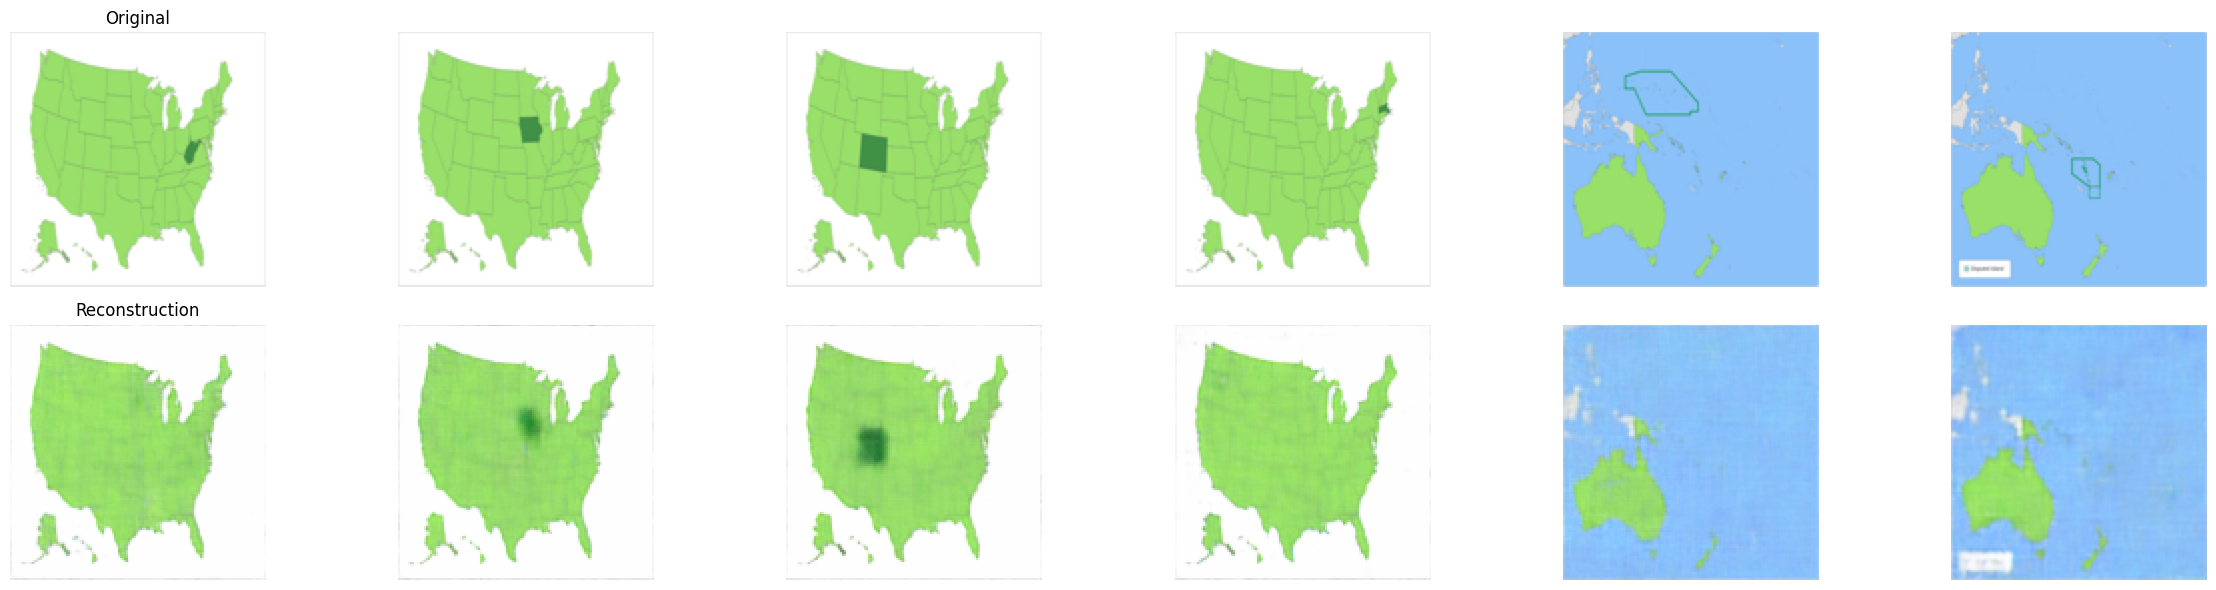

In [13]:
show_reconstructions_for_topic(split="train", topic="geography", n=6, random_seed=2)


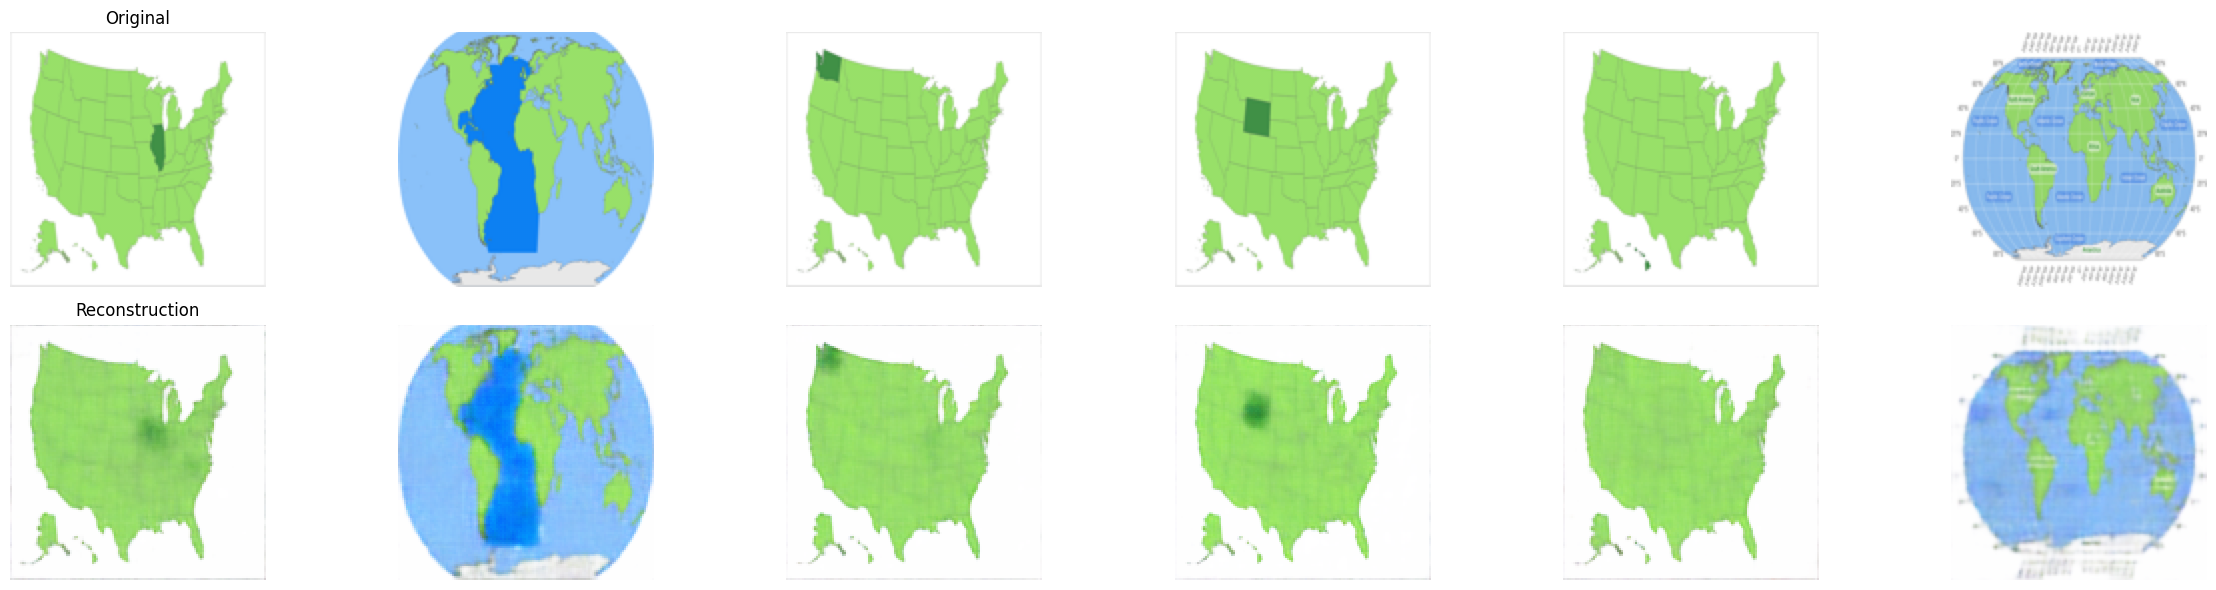

In [14]:
show_reconstructions_for_topic(split="train", topic="geography", n=6, random_seed=5)


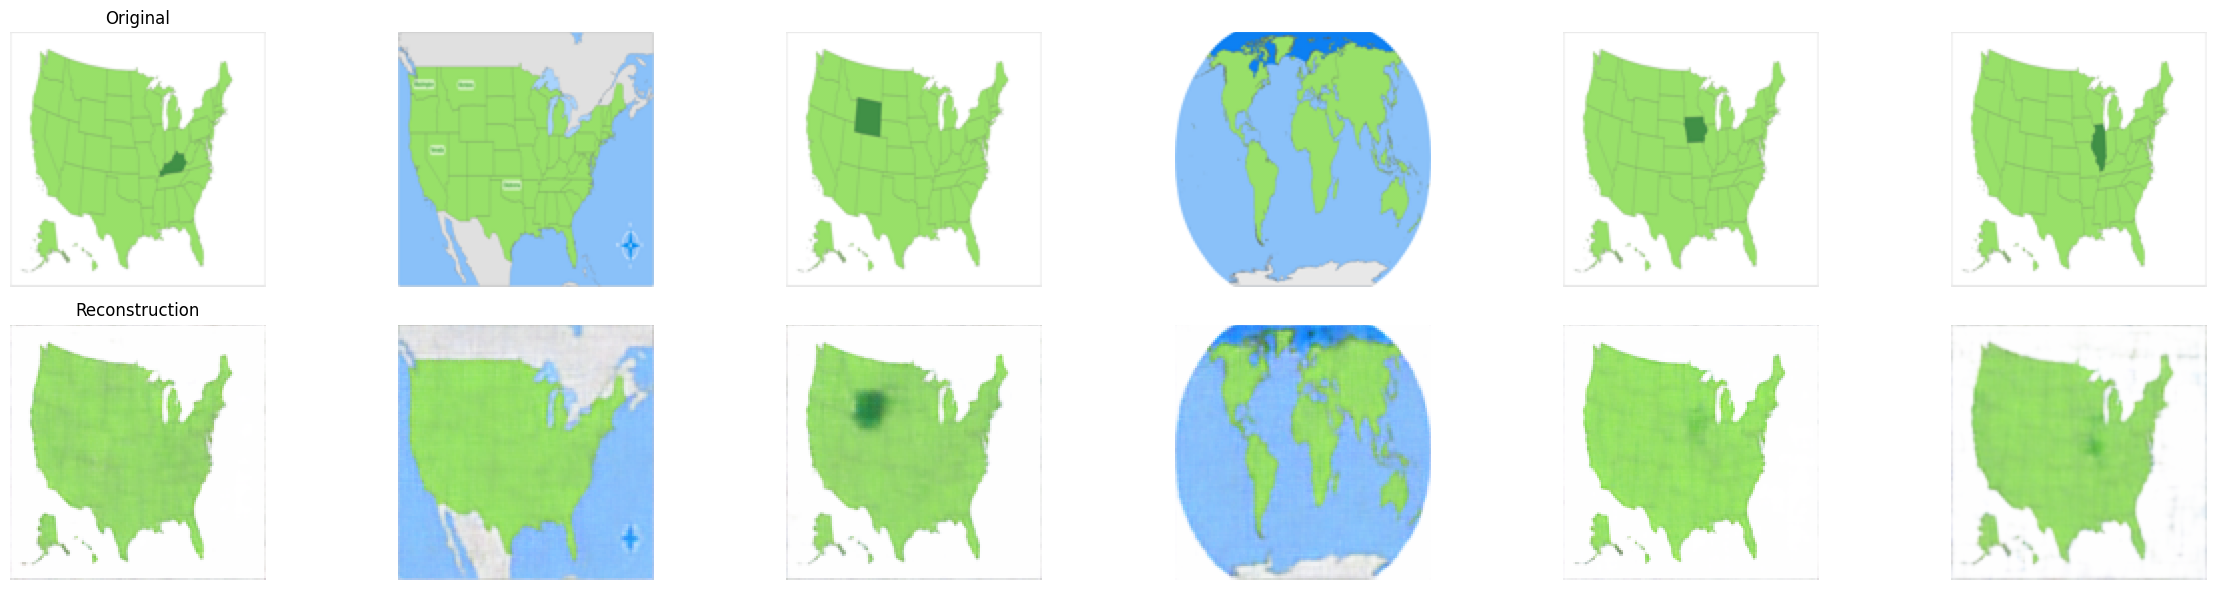

In [15]:
show_reconstructions_for_topic(split="train", topic="geography", n=6, random_seed=60)


In [16]:
# -----------------------
# Metrics computation snippet (append after training/eval)
# -----------------------
import math
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from scipy import linalg
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input as inception_preprocess

# ---- Config ----
NUM_SAMPLES = 500           # how many images to sample for metrics (reduce if memory/time constrained)
BATCH_METRIC = 64
INCEPTION_SIZE = 299       # InceptionV3 input size
RANDOM_SEED = 42

# ---- Utility: gather N originals + reconstructions from a tf.data.Dataset or HF ds split ----
def gather_originals_and_recons_from_tfds(tf_dataset, vae_model, num_samples=NUM_SAMPLES):
    originals = []
    recons = []
    cnt = 0
    for batch in tf_dataset:
        # batch: shape (B,H,W,C) with values in [0,1]
        recon_batch = vae_model(batch, training=False).numpy()
        orig_batch = batch.numpy()
        batch_size = orig_batch.shape[0]
        for i in range(batch_size):
            originals.append(orig_batch[i])
            recons.append(recon_batch[i])
            cnt += 1
            if cnt >= num_samples:
                break
        if cnt >= num_samples:
            break
    originals = np.asarray(originals)[:num_samples]
    recons = np.asarray(recons)[:num_samples]
    return originals, recons

# If you want to sample from HF dataset 'ds' directly (useful if tf datasets were downsampled), use this:
def gather_from_hf_split(split_name="validation", num_samples=NUM_SAMPLES):
    originals = []
    recons = []
    idxs = []
    for i, ex in enumerate(ds[split_name]):
        if ex.get("image", None) is None:
            continue
        arr = preprocess_pil_image(ex["image"])
        originals.append(arr)
        idxs.append(i)
        if len(originals) >= num_samples:
            break
    originals = np.array(originals[:num_samples], dtype=np.float32)
    # compute recons using vae
    recon_batches = []
    for i in range(0, originals.shape[0], BATCH_METRIC):
        batch = originals[i:i+BATCH_METRIC]
        batch_tf = tf.convert_to_tensor(batch)
        recon_tf = vae(batch_tf, training=False)
        recon_batches.append(recon_tf.numpy())
    recons = np.vstack(recon_batches)[:num_samples]
    return originals, recons

# ---- choose source and gather ----
# Option A: from your downsampled tf.data 'val_ds' or 'train_ds'
# originals, recons = gather_originals_and_recons_from_tfds(val_ds, vae, num_samples=NUM_SAMPLES)

# Option B: from HF split directly (works reliably)
originals, recons = gather_from_hf_split(split_name="validation", num_samples=NUM_SAMPLES)
print(f"Collected {originals.shape[0]} original images and {recons.shape[0]} reconstructions")

# ---- Basic per-image metrics: MSE, MAE, SSIM ----
def compute_mse_mae_ssim_batch(orig, recon):
    # orig, recon shape (N,H,W,C), values in [0,1]
    mse = np.mean((orig - recon)**2, axis=(1,2,3))
    mae = np.mean(np.abs(orig - recon), axis=(1,2,3))
    # SSIM compute per image using tf.image.ssim
    ssim_vals = []
    for i in range(orig.shape[0]):
        s = tf.image.ssim(orig[i], recon[i], max_val=1.0).numpy()
        ssim_vals.append(float(s))
    ssim_vals = np.array(ssim_vals)
    return mse, mae, ssim_vals

mse_vals, mae_vals, ssim_vals = compute_mse_mae_ssim_batch(originals, recons)
print(f"MSE (mean ± std) : {mse_vals.mean():.6f} ± {mse_vals.std():.6f}")
print(f"MAE (mean ± std) : {mae_vals.mean():.6f} ± {mae_vals.std():.6f}")
print(f"SSIM (mean ± std): {ssim_vals.mean():.4f} ± {ssim_vals.std():.4f}")


Collected 500 original images and 500 reconstructions
MSE (mean ± std) : 0.007712 ± 0.009950
MAE (mean ± std) : 0.045278 ± 0.034165
SSIM (mean ± std): 0.6955 ± 0.2137


In [18]:

# ---- Prepare InceptionV3 model for embeddings (for FID and cosine similarity) ----
inception_model = InceptionV3(include_top=False, pooling="avg", input_shape=(INCEPTION_SIZE, INCEPTION_SIZE, 3))

def get_inception_activations(images):
    """
    images: numpy array shape (N,H,W,C) values in [0,1]
    returns: activations shape (N, feat_dim)
    """
    # Resize to INCEPTION_SIZE and scale to 0-255 for preprocess_input
    imgs_resized = tf.image.resize(images, (INCEPTION_SIZE, INCEPTION_SIZE)).numpy() * 255.0
    imgs_proc = inception_preprocess(imgs_resized)  # scales to model expected range
    activations = inception_model.predict(imgs_proc, batch_size=BATCH_METRIC, verbose=0)
    return activations

print("Computing Inception activations (may take a while)...")
orig_acts = get_inception_activations(originals)
recon_acts = get_inception_activations(recons)
print("Activations shapes:", orig_acts.shape, recon_acts.shape)

# ---- FID computation ----
def calculate_fid(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """
    mu1, sigma1: mean and covariance of activations for set 1
    mu2, sigma2: mean and covariance for set 2
    """
    diff = mu1 - mu2
    # sqrt of product of covariances
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    # numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * np.trace(covmean)
    return float(np.real(fid))

mu_orig = np.mean(orig_acts, axis=0)
sigma_orig = np.cov(orig_acts, rowvar=False)
mu_recon = np.mean(recon_acts, axis=0)
sigma_recon = np.cov(recon_acts, rowvar=False)

fid_value = calculate_fid(mu_orig, sigma_orig, mu_recon, sigma_recon)
print(f"FID between originals and reconstructions (lower better): {fid_value:.4f}")


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Computing Inception activations (may take a while)...
Activations shapes: (500, 2048) (500, 2048)


/tmp/ipython-input-628984618.py:28: DeprecationWarning: The `disp` argument is deprecated and will be removed in SciPy 1.18.0.
  covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)


FID between originals and reconstructions (lower better): 184.7342


In [19]:

# ---- Cosine similarity between original & reconstruction embeddings (per-image) ----
# compute cosine between corresponding pairs using Inception activations
cos_sims = []
for i in range(orig_acts.shape[0]):
    a = orig_acts[i].reshape(1, -1)
    b = recon_acts[i].reshape(1, -1)
    cos = cosine_similarity(a, b)[0][0]
    cos_sims.append(cos)
cos_sims = np.array(cos_sims)
print(f"Cosine similarity (embedding) mean ± std: {cos_sims.mean():.6f} ± {cos_sims.std():.6f}")


Cosine similarity (embedding) mean ± std: 0.644214 ± 0.123782


In [20]:

# ---- Diversity metrics ----
# 1) Entropy of grayscale histogram across reconstructions (average over images)
def image_entropy(image, num_bins=256):
    # image in [0,1], compute grayscale histogram entropy (Shannon)
    gray = np.mean(image, axis=2)  # HxW
    hist, _ = np.histogram((gray * 255).astype(np.uint8).ravel(), bins=num_bins, range=(0,255), density=True)
    # avoid zeros
    hist = hist + 1e-12
    ent = -np.sum(hist * np.log(hist))
    return ent

entropies = [image_entropy(im) for im in recons]
print(f"Average entropy of reconstructions (Grayscale histogram): {np.mean(entropies):.4f} ± {np.std(entropies):.4f}")

# 2) Dist-N: average pairwise Euclidean distance between embeddings (Inception activations)
# We'll compute average pairwise distance for a subset (to limit computation)
def avg_pairwise_distance(acts, sample_limit=500):
    n = acts.shape[0]
    idxs = np.arange(n)
    if n > sample_limit:
        rng = np.random.default_rng(RANDOM_SEED)
        idxs = rng.choice(n, size=sample_limit, replace=False)
    acts_s = acts[idxs]
    # pairwise distances
    # compute squared norms trick
    sq = np.sum(acts_s**2, axis=1, keepdims=True)
    dists = np.sqrt(np.maximum(sq + sq.T - 2 * acts_s.dot(acts_s.T), 0.0))
    # take upper triangle mean
    triu_idx = np.triu_indices_from(dists, k=1)
    avg = np.mean(dists[triu_idx])
    return avg

avg_dist_recon = avg_pairwise_distance(recon_acts, sample_limit=200)
avg_dist_orig = avg_pairwise_distance(orig_acts, sample_limit=200)
print(f"Avg pairwise embedding distance (orig): {avg_dist_orig:.4f}")
print(f"Avg pairwise embedding distance (recon): {avg_dist_recon:.4f}")


Average entropy of reconstructions (Grayscale histogram): 3.7397 ± 1.0219
Avg pairwise embedding distance (orig): 18.7593
Avg pairwise embedding distance (recon): 18.6714


In [21]:

# ---- Summary printout ----
print("\n--- Summary Metrics ---")
print(f"Samples used: {originals.shape[0]}")
print(f"MSE (mean): {mse_vals.mean():.6f}")
print(f"MAE (mean): {mae_vals.mean():.6f}")
print(f"SSIM (mean): {ssim_vals.mean():.4f}")
print(f"FID: {fid_value:.4f}")
print(f"Cosine similarity (mean): {cos_sims.mean():.6f}")
print(f"Reconstruction entropy (mean): {np.mean(entropies):.4f}")
print(f"Avg pairwise embedding distance - originals: {avg_dist_orig:.4f}, reconstructions: {avg_dist_recon:.4f}")



--- Summary Metrics ---
Samples used: 500
MSE (mean): 0.007712
MAE (mean): 0.045278
SSIM (mean): 0.6955
FID: 184.7342
Cosine similarity (mean): 0.644214
Reconstruction entropy (mean): 3.7397
Avg pairwise embedding distance - originals: 18.7593, reconstructions: 18.6714
